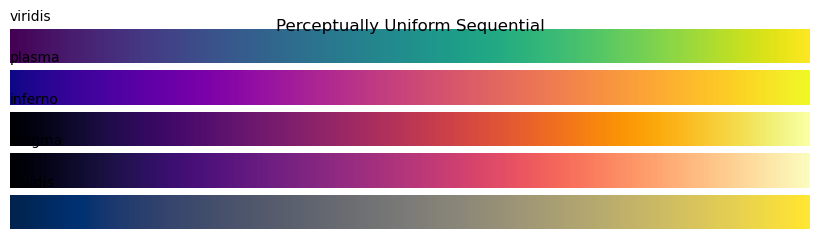

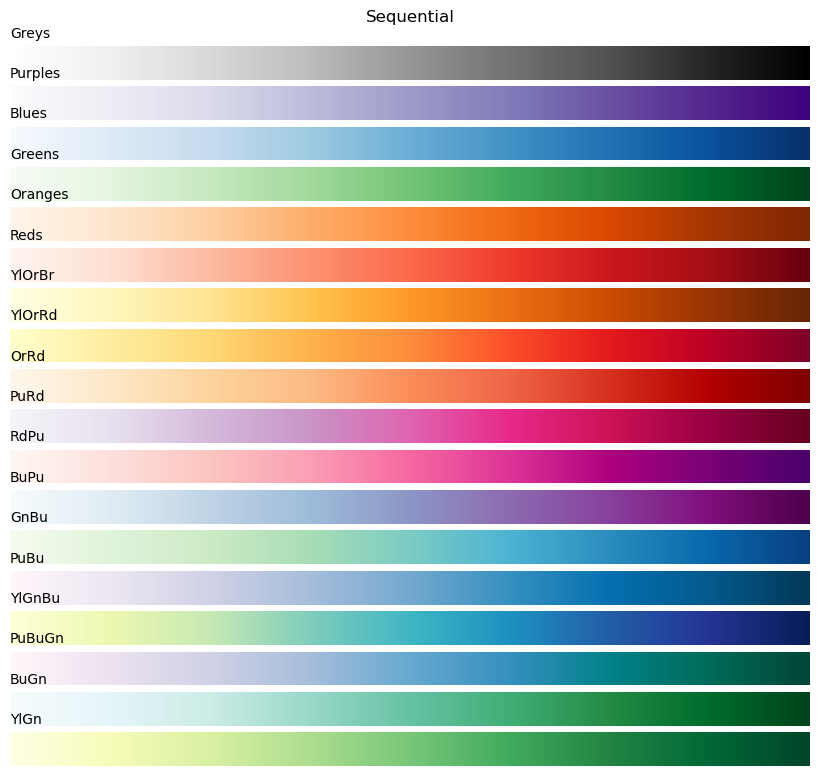

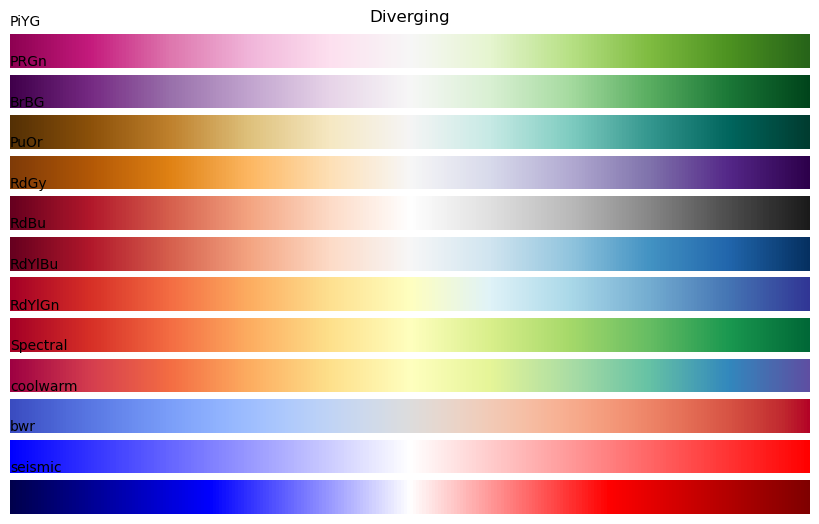

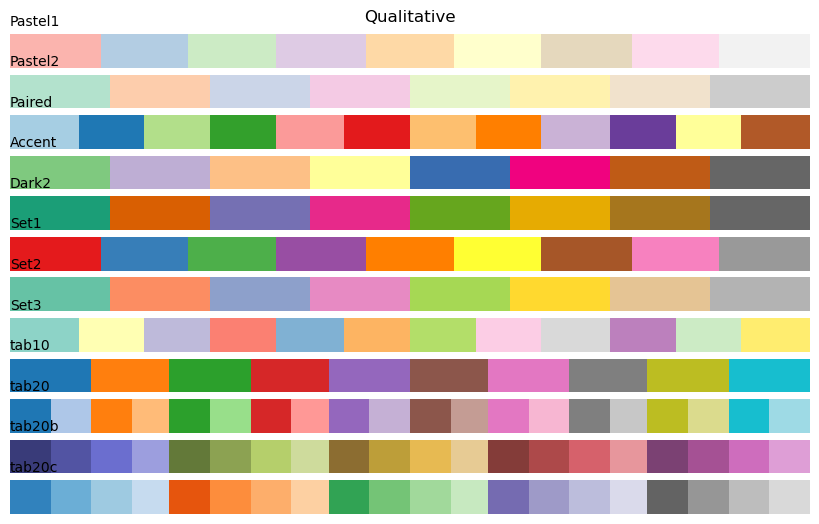

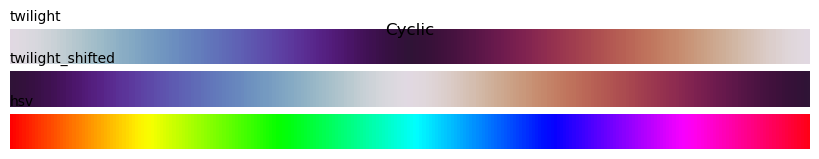

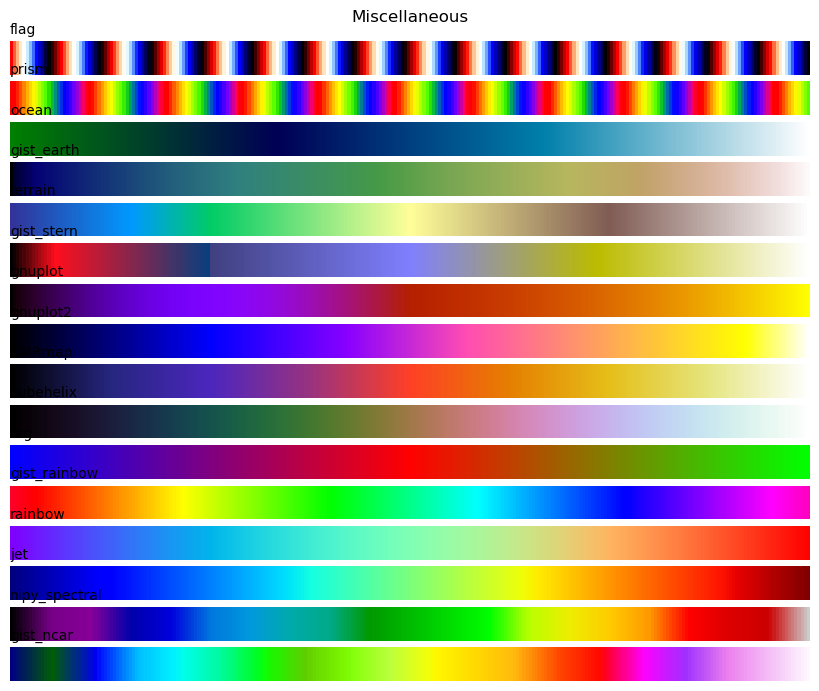

In [1]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.training_loop import run_training_loop
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.scheduler_utils import create_scheduler
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [2]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config(config_path="config/vit_" \
# "bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs32_ep50_lr1e-04_ds1000-g1.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")
# cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Extracted dataset_size from path: 1000
{
  "model_tag": "ConvNeXt_GAUSSIAN",
  "backbone": "convnext_gaussian",
  "batch_size": 512,
  "epochs": 2,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled",
  "train_csv": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/file_labels_train.cs

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau


In [4]:
device= get_device_summary()

=== NVIDIA-SMI ===
Fri Aug  1 17:23:33 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   33C    P5              26W / 220W |    816MiB /  8192MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using model: convnext_tiny, pretrained: False


ConvNeXtClassifier(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_

In [7]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [8]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [9]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [10]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [11]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json


In [12]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [13]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [14]:
best_epoch,best_acc,best_metrics=run_training_loop(
                      cfg,train_loader,val_loader,
                      device, model,criterion,
                      optimizer,scheduler,
                      start_epoch,early_stop_counter,
                      best_acc,best_metrics,best_epoch,
                      train_loss_list,
                        train_loss_energy_list,
                        train_loss_alpha_list,
                        train_loss_q0_list,
                        train_acc_list,
                        train_acc_energy_list,
                        train_acc_alpha_list,
                        train_acc_q0_list,
                        val_loss_list,
                        val_loss_energy_list,
                        val_loss_alpha_list,
                        val_loss_q0_list,
                        val_acc_list,
                        val_acc_energy_list,
                        val_acc_alpha_list,
                        val_acc_q0_list,
                        all_epoch_metrics)

[INFO] Epoch 1/2


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3438, Q0 Acc = 0.3438, Total Acc = 0.1042
[INFO] Epoch 1: Energy Loss =0.5732, αs Loss = 1.1396, Q0 Loss = 1.3972, Total Loss = 3.1101
📉 Current LR: 0.0001
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
✅ Best model saved at epoch 1 with total accuracy: 0.1042
[INFO] Epoch 2/2


[INFO] Epoch 2: Energy Acc =0.7500, αs Acc = 0.3229, Q0 Acc = 0.2708, Total Acc = 0.1042
[INFO] Epoch 2: Energy Loss =0.5621, αs Loss = 1.1841, Q0 Loss = 1.4361, Total Loss = 3.1823
📉 Current LR: 0.0001
[INFO] Epoch 2: Saving metrics to disk
💾 Last model saved at epoch 2
⏳ No improvement. Early stop counter: 1/12


In [15]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json

🏁 Best Model @ Epoch 1
Total Accuracy: 0.1042

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286
  Confusion Matrix:
[[0, 24], [0, 72]]

🔹 ALPHA Task
  Accuracy : 0.3438
  Precision: 0.2802
  Recall   : 0.3438
  F1-Score : 0.2051
  Confusion Matrix:
[[0, 31, 1], [0, 31, 1], [1, 29, 2]]

🔹 Q0 Task
  Accuracy : 0.3438
  Precision: 0.3482
  Recall   : 0.3438
  F1-Score : 0.2856
  Confusion Matrix:
[[1, 18, 2, 3], [0, 20, 3, 1], [2, 16, 3, 3], [1, 11, 3, 9]]


📊 Plots saved to:
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.png
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.pdf


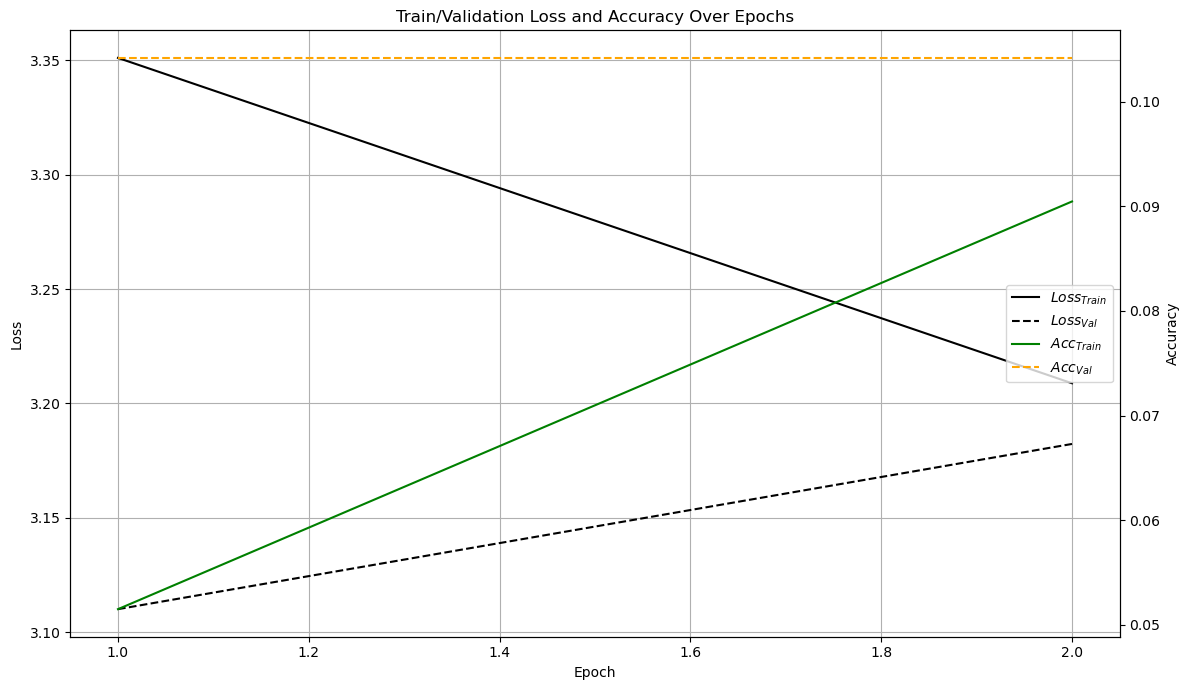

📉 Loss plot saved as:
  - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.pdf


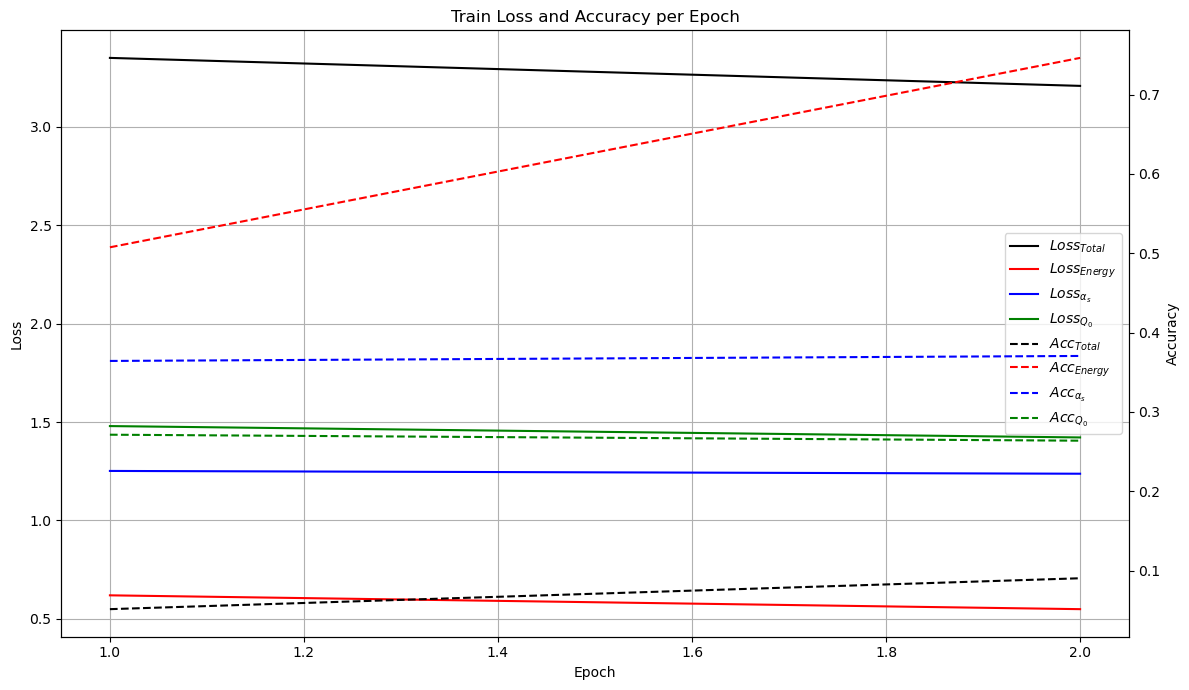

📉 Loss plot saved as:
  - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.pdf


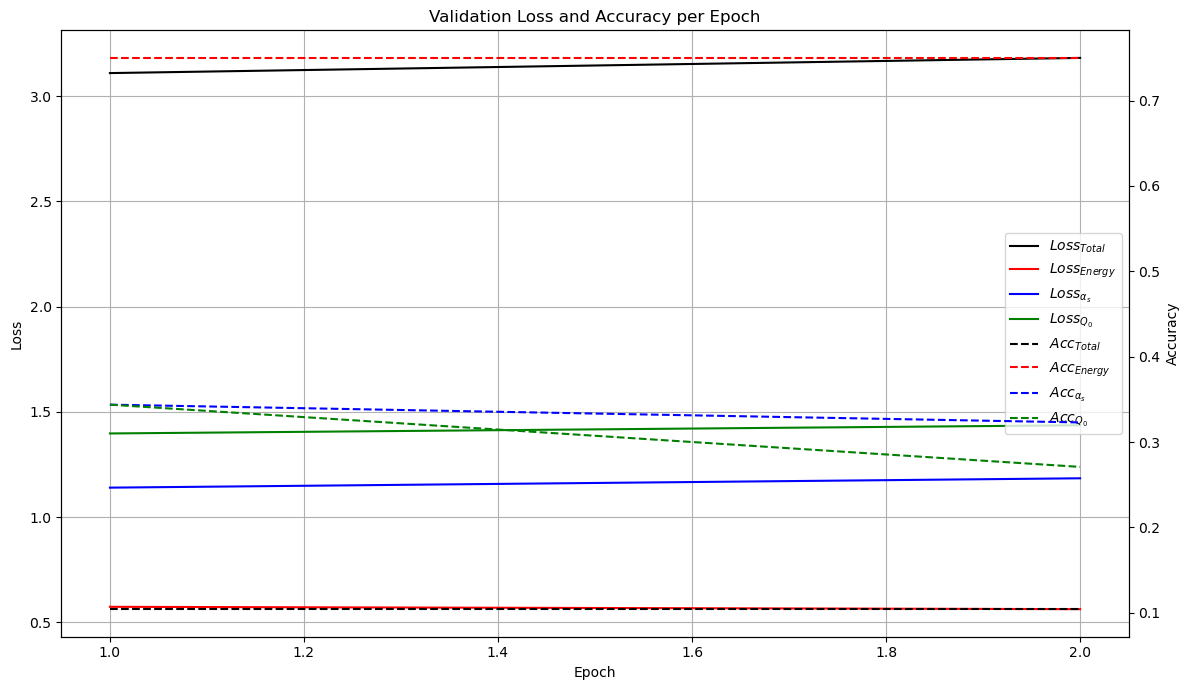

In [16]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")

✅ Saved confusion matrix for energy:
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_energy.png
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_energy.pdf


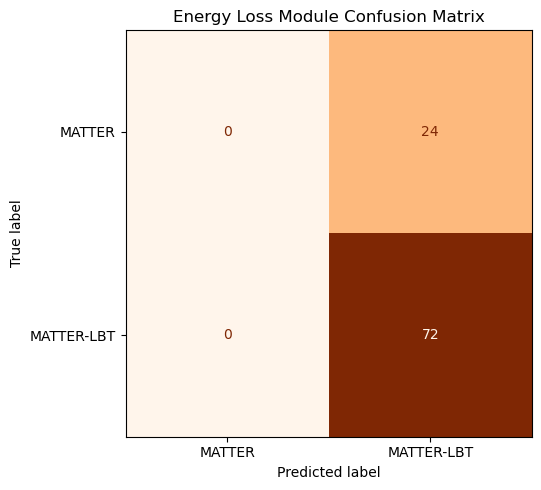

✅ Saved confusion matrix for alpha:
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_alpha.png
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_alpha.pdf


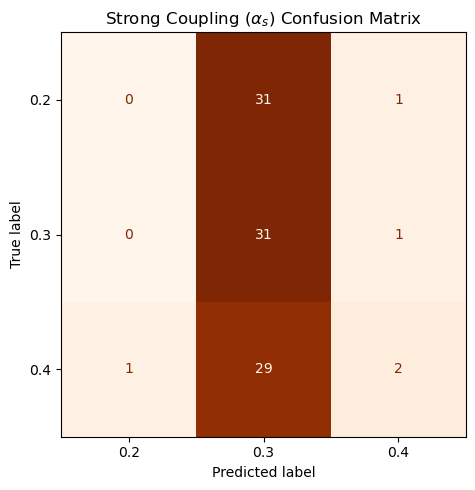

✅ Saved confusion matrix for q0:
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_q0.png
 - training_output/ConvNeXt_GAUSSIAN_bs512_ep2_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_q0.pdf


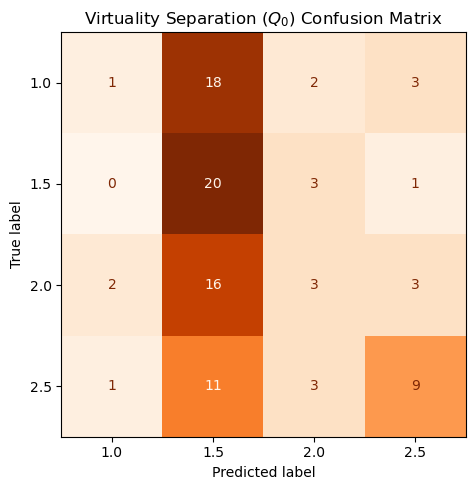

In [17]:
plot_confusion_matrices(best_metrics, output_dir=cfg.output_dir, color_map="Oranges")